In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib import cm
from matplotlib import animation
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import networkx as nx

### A Look at Consumer Complaints for Financial Instituions

#### Data is sourced from the Consumer Financial Protection Bureau

https://www.consumerfinance.gov/data-research/consumer-complaints/

From source:\
The Consumer Complaint Database is a collection of complaints about consumer financial products and services that we sent to companies for response. Complaints are published after the company responds, confirming a commercial relationship with the consumer, or after 15 days, whichever comes first. Complaints referred to other regulators, such as complaints about depository institutions with less than $10 billion in assets, are not published in the Consumer Complaint Database.

In [2]:
complaints_df = pd.DataFrame()
cols = ['Date received', 
        'Product', 
        'Sub-product', 
        'Issue', 
        'Sub-issue',
        'Consumer complaint narrative', 
        'Company public response', 
        'Company', 
        'State', 
        'Date sent to company', 
        'Company response to consumer', 
        'Timely response?', 
        'Consumer disputed?']
for c in pd.read_csv('data/Consumer_Complaints.csv', chunksize = 10000, header=0, usecols=cols):
    complaints_df = complaints_df.append(c)

In [3]:
complaints_df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?
0,09/20/2019,Debt collection,Other debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"CCS Financial Services, Inc.",IL,09/20/2019,Closed with explanation,Yes,NaN
1,09/20/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with fraud alerts or security freezes,NaN,NaN,NaN,"ONEMAIN FINANCIAL HOLDINGS, LLC.",WA,09/20/2019,In progress,Yes,NaN
2,09/20/2019,Checking or savings account,Checking account,Managing an account,Problem accessing account,NaN,NaN,ALLY FINANCIAL INC.,CA,09/20/2019,In progress,Yes,NaN
3,09/20/2019,Debt collection,Medical debt,Attempts to collect debt not owed,Debt was result of identity theft,NaN,NaN,"Commonwealth Financial Systems, Inc.",NV,09/20/2019,Closed with explanation,Yes,NaN
4,09/20/2019,"Payday loan, title loan, or personal loan",Payday loan,Can't stop withdrawals from your bank account,NaN,NaN,NaN,"Tennessee Quick Cash, Inc.",TN,09/20/2019,In progress,Yes,NaN


In [4]:
print(str(complaints_df.iloc[-1, 0]) + ' - ' + str(complaints_df.iloc[0, 0]))

12/01/2011 - 09/20/2019


#### Get complaints from years January 1, 2012 through June 30, 2019 to match up quarterly time frames

In [5]:
complaints_df['Date received'] = pd.to_datetime(complaints_df['Date received'], format='%m/%d/%Y')
complaints_df['Date sent to company'] = pd.to_datetime(complaints_df['Date sent to company'], format='%m/%d/%Y')
complaints_df['Company'] = complaints_df['Company'].str.strip()
complaints_df_cut = complaints_df[(complaints_df['Date received'] >= pd.to_datetime('01/01/2012', format='%m/%d/%Y')) &
           (complaints_df['Date received'] <= pd.to_datetime('06/30/2019', format='%m/%d/%Y'))]
print(str(complaints_df_cut.iloc[-1, 0]) + ' - ' + str(complaints_df_cut.iloc[0, 0]))

2012-01-01 00:00:00 - 2019-06-30 00:00:00


#### Take a glance at a single example from this dataset

In [6]:
df_equifax = complaints_df_cut[complaints_df_cut['Company'] == 'EQUIFAX, INC.']
equifax_complaints = df_equifax['Date received'].value_counts()

# Aggregate by month
equifax_complaints = df_equifax.groupby(by=[df_equifax['Date received'].dt.year, 
                                            df_equifax['Date received'].dt.month])['Date received'].value_counts()
equifax_complaints = equifax_complaints.groupby([equifax_complaints.index.get_level_values(0),
                                                equifax_complaints.index.get_level_values(1)]).sum()

In [7]:
print(str(df_equifax.iloc[-1, 0]) + ' - ' + str(df_equifax.iloc[0, 0])) # Range of the data

2012-10-14 00:00:00 - 2019-06-30 00:00:00


In [8]:
equifax_complaints

Date received  Date received
2012           10                127
               11                265
               12                230
2013           1                 271
               2                 372
                                ... 
2019           2                2571
               3                3206
               4                3145
               5                3339
               6                3518
Name: Date received, Length: 81, dtype: int64

#### Plot the Equifax subset

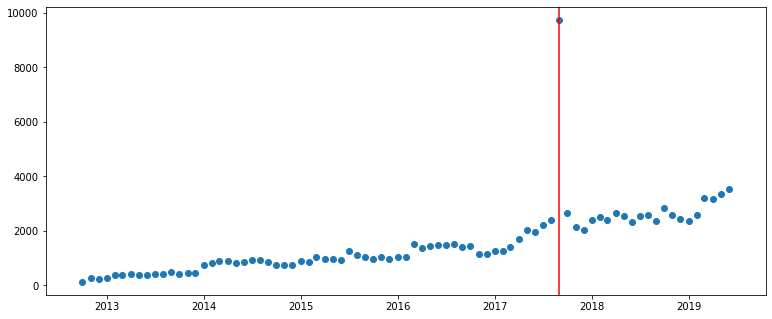

In [9]:
equifax_complaints_index = pd.to_datetime({'year': equifax_complaints.index.get_level_values(0),
                                           'month': equifax_complaints.index.get_level_values(1),
                                           'day': 1})
fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])
ax.scatter(y = equifax_complaints, x = equifax_complaints_index)
ax.axvline(x=pd.to_datetime('09/01/2017', format='%m/%d/%Y'), color='r')

plt.show()

#### We can see that consumer complaints for Equifax have increased over time. There is an outlier for the month of September 2017, which coincides with the large databreach at Equifax at that time. 

#### The consumer complaints data in of itself is of limited use. Unsurprisingly, we can see that that large firms that service many consumers also recieve many complaints. We won't know whether they recieve a disproportionate amount unless we scale by some metric, for example the number of consumer accounts each company holds.

In [10]:
# Aggregate Complaints across all years
complaints_df.groupby('Company').size().sort_values(ascending=False).head(10) 

Company
EQUIFAX, INC.                             131563
Experian Information Solutions Inc.       117384
TRANSUNION INTERMEDIATE HOLDINGS, INC.    112649
BANK OF AMERICA, NATIONAL ASSOCIATION      85179
WELLS FARGO & COMPANY                      73834
JPMORGAN CHASE & CO.                       63434
CITIBANK, N.A.                             51669
CAPITAL ONE FINANCIAL CORPORATION          37418
Navient Solutions, LLC.                    30553
OCWEN FINANCIAL CORPORATION                28371
dtype: int64

#### The credit reporting agencies dominate the total number of complains in the dataset

### Which Financial Institutions have the most complaints per consumer account?

#### Thankfully, we can obtain information on the number of consumer accounts from the FDIC. 

https://www.fdic.gov/bank/statistical/

In [11]:
import os
accnts_df = pd.DataFrame()
directory = 'data/transaction_accounts'
for file in os.listdir(directory):
    quarter = pd.to_datetime(file.split('_')[2], format='%Y%m%d') # Get the date info from filename
    # 'trnipcoc' corresponds to the number of accounts from 'Individuals, partnerships and corporations'
    temp_df = pd.read_csv(os.path.join(directory,file), header=0, usecols=['namehcr', 'trnipcoc'])
    temp_df = temp_df.dropna()
    temp_df['date'] = quarter
    accnts_df = accnts_df.append(temp_df)
accnts_df.columns = ['company', 'num_indiv_accnts', 'date']
accnts_df = pd.DataFrame(accnts_df.groupby(by=['date', 'company']).sum())
accnts_df = accnts_df.reset_index()
accnts_df['company'] = accnts_df['company'].str.strip()

#### Though this data set contains many of the relevant instituions, it doesn't contain all of the financial institutions from the complaints dataset, namely the credit reporting agencies.

In [12]:
[l for l in accnts_df['company'] if 'Equifax' in l or 'EQUIFAX' in l]

[]

#### We need to alter the complaints data to conform  to the accounts data

In [13]:
# Reduce the complaints df to just the counts
complaints_count = complaints_df_cut[['Date received', 'Company']]
complaints_count = complaints_count.dropna()
complaints_count.columns = ['date', 'company']
# Convert to quarterly (accounts data is quarterly) counts for each company
complaints_count = complaints_count.groupby(by=[complaints_count['date'].dt.to_period('Q'), 'company'])['date'].size()
complaints_count = pd.DataFrame(complaints_count)
complaints_count.columns = ['complaints']
complaints_count = complaints_count.reset_index()
complaints_count.sort_values(by='complaints', ascending=False).head(10)

,date,company,complaints
29195,2017Q3,"EQUIFAX, INC.",14348
43308,2019Q2,"EQUIFAX, INC.",10002
44444,2019Q2,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",9831
43344,2019Q2,Experian Information Solutions Inc.,9243
41388,2019Q1,"EQUIFAX, INC.",8131
41427,2019Q1,Experian Information Solutions Inc.,7848
39441,2018Q4,"EQUIFAX, INC.",7822
33311,2018Q1,Experian Information Solutions Inc.,7765
35399,2018Q2,Experian Information Solutions Inc.,7748
42449,2019Q1,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",7618


#### Like above, we can see that the credit reporting agencies also dominate the number of complaints on a quarterly basis.

#### An issue arises when on tries to naively merge the accounts data with the complaints data. The issue is that the complaints is often filed under different subsidiaries from the accounts data. We need a means of merging all the complaints and accounts from the subsidiaries.

#### Here's an example:

In [14]:
complaints_count[complaints_count['company'] == 'BANK OF AMERICA, NATIONAL ASSOCIATION'].head()

,date,company,complaints
22,2012Q1,"BANK OF AMERICA, NATIONAL ASSOCIATION",2885
219,2012Q2,"BANK OF AMERICA, NATIONAL ASSOCIATION",5000
469,2012Q3,"BANK OF AMERICA, NATIONAL ASSOCIATION",4441
745,2012Q4,"BANK OF AMERICA, NATIONAL ASSOCIATION",3722
1047,2013Q1,"BANK OF AMERICA, NATIONAL ASSOCIATION",5975


In [15]:
accnts_df[accnts_df['company'] == 'BANK OF AMERICA, NATIONAL ASSOCIATION'].head()

,date,company,num_indiv_accnts


In [16]:
accnts_df[accnts_df['company'] == 'BANK OF AMERICA CORPORATION'].head()

,date,company,num_indiv_accnts
321,2012-03-31,BANK OF AMERICA CORPORATION,140114965
5173,2012-06-30,BANK OF AMERICA CORPORATION,136984204
9992,2012-09-30,BANK OF AMERICA CORPORATION,147325270
14787,2012-12-31,BANK OF AMERICA CORPORATION,158349295
19518,2013-03-31,BANK OF AMERICA CORPORATION,142882000


#### The complaints for Bank of America are filed under their subsidiary "Bank of America, National Assocation", while the data regarding the number of accounts is under the parent company "Bank of America Corporation". While we could use some means of matching the company names, this is not a fool proof solution. Instead we need to obtain information regarding the relationship of parent and subsidaries. We will use this information to link these two.

### Attributes and Relationships Data

#### Instead of matching on company name and matching text, we can use the identification number assigned to these instutions by the Federal Reserve. The FFIEC provides this data. 

https://www.ffiec.gov/npw/FinancialReport/DataDownload

In [17]:
attributes_df = pd.read_csv('data/CSV_ATTRIBUTES_ACTIVE.CSV', header=0, usecols=['#ID_RSSD', 'NM_LGL', 'NM_SHORT'])
attributes_df.columns = ['id', 'company', 'company_short']
attributes_df['company'] = attributes_df['company'].str.strip()
attributes_df.head()

,id,company,company_short
0,37,BANK OF HANCOCK COUNTY,BANK OF HANCOCK CTY
1,73,UTILITY EMPLOYEES FEDERAL CREDIT UNION,UTILITY EMPL FCU
2,242,FIRST COMMUNITY BANK XENIA-FLORA,FIRST CMNTY BK XENIA FLORA
3,279,"MINEOLA COMMUNITY BANK, SSB",MINEOLA CMNTY BK SSB
4,354,BISON STATE BANK,BISON ST BK


#### In addition, they provide parent and subsidiary information which we will use to match companies.

In [18]:
relationships_df = pd.read_csv('data/CSV_RELATIONSHIPS.CSV', header=0, usecols=['#ID_RSSD_PARENT', 'ID_RSSD_OFFSPRING', 'D_DT_END'])
relationships_df.columns = ['id_parent', 'id', 'end_date']
relationships_df['end_year'] = relationships_df['end_date'].str.split().apply(lambda x: x[0]).str.split('/').apply(lambda x: int(x[-1]))
relationships_df.loc[relationships_df['end_year'] == 9999, 'end_date'] = None # Make current relationship end_dates None for datetime conversion
relationships_df['end_date'] = pd.to_datetime(relationships_df['end_date'])
relationships_df.head()

,id_parent,id,end_date,end_year
0,130,1081305,1986-02-14,1986
1,279,3923155,NaT,9999
2,505,2913168,2007-06-29,2007
3,505,2913168,NaT,9999
4,505,3079566,2003-02-12,2003


#### We will now merge our prior data with this new id data

In [19]:
# Get the id's for each company and merge to the accounts data
accnts_df = accnts_df.merge(attributes_df, on='company', how='left')
# Get the parent (na they have none) for each company
accnts_df = accnts_df.merge(relationships_df, on='id', how='left')

# Likewise for the complaints data
complaints_count = complaints_count.merge(attributes_df, on='company', how='left')
complaints_count = complaints_count.merge(relationships_df, on='id', how='left')

# Get ids for companies who has no parent, presently has a parent, or had a parent through the data collection date
complaints_count = complaints_count[(complaints_count['end_date'].isnull()) | (complaints_count['date'].dt.start_time < complaints_count['end_date'])]
accnts_df = accnts_df[(accnts_df['end_date'].isnull()) | (accnts_df['date'] < accnts_df['end_date'])]
accnts_df['date'] = accnts_df['date'].dt.to_period('Q') # Convert date to quarterly to reconcile with complaints

#### Now we finally merge our accounts data with our complaints data by the id of the company

In [20]:
parent_child_df = accnts_df.merge(complaints_count, how='outer', on=['date', 'company', 'id', 'company_short', 'id_parent', 'end_date', 'end_year'])
parent_child_df = parent_child_df.drop(['end_date', 'end_year'], axis=1)

## Sum up any company's complaints and number of accounts for each time period
# Will be used to replace duplicate company/date rows
temp_replace = pd.DataFrame(parent_child_df.groupby(by=['date', 'id'])['complaints', 'num_indiv_accnts'].sum())
## Grab the first of each company/date row
# Sort on id_parent. If there is one make it first', rest of data will be replaced
parent_child_df = parent_child_df.sort_values('id_parent').groupby(['date', 'id']).first()
# Now do the replacement
parent_child_df = parent_child_df.drop(['complaints', 'num_indiv_accnts'], axis=1).merge(temp_replace, on=['date','id'], how='inner')

In [21]:
parent_child_df.head()

company  \
date   id                                              
2012Q1 12311.0         HUNTINGTON NATIONAL BANK, THE   
       30810.0                         DISCOVER BANK   
       35570.0                        INVESTORS BANK   
       49054.0                         COMMERCE BANK   
       75633.0  BMO HARRIS BANK NATIONAL ASSOCIATION   

                                 company_short  id_parent  complaints  \
date   id                                                               
2012Q1 12311.0  HUNTINGTON NB                   1068191.0        25.0   
       30810.0  DISCOVER BK                     3846375.0       182.0   
       35570.0  INVESTORS BK                    2476869.0         2.0   
       49054.0  COMMERCE BK                     2452630.0         9.0   
       75633.0  BMO HARRIS BK NA                1245415.0        31.0   

                num_indiv_accnts  
date   id                         
2012Q1 12311.0               0.0  
       30810.0               0.0  
       35570.0               0.0  
       49054.0               0.0  
       75633.0               0.0

#### So far we've merged data under the same company; however, we still need to merge our parent and subsidiaries. First we identify all of our subsidiaries

#### We use the relationships dataset to construct a social network of companies and get_root_nodes will find the ultimate parent of a given node

In [22]:
relationships_graph = nx.from_pandas_edgelist(df=relationships_df, source='id_parent', target='id',edge_attr=['end_date'], create_using=nx.DiGraph())

In [23]:
# Use the graph of parents and subsidiaries to recurse back to the root of each subsidiary node
def get_root_nodes(node, g, passed_path = []):
    parents = list(g.predecessors(node)) # All the parents of the node across different time periods
    if passed_path:
        path = passed_path
    else:
        path = []
    newest_parent = None
    newest_date = pd.Timestamp(0)
    for p in parents: # Get the most current relationship
        edge_data = g.get_edge_data(p, node) # Get the termination date of a relationship
        if edge_data and pd.isna(edge_data['end_date']): # If relationship is null that means it is still active
            newest_parent = p
            newest_date = None
            break # If there is a current relationship don't even look at the others
        elif edge_data and edge_data['end_date'] > newest_date: # If no current relationships then just get the most current
            newest_parent = p
            newest_date = edge_data['end_date']
    if list(filter(lambda x: newest_parent == x[0], path)): # There is a loop in graph A->B->A, repeat process on nodes we've touched
        newest_node = None
        newest_date = pd.Timestamp(0)
        for n in path:
            if pd.isna(n[1]): # Relationship is current (null), return this
                return n[0]
            elif n[1] > newest_date: # Otherwise get most recent one
                newest_node = n[0]
                newest_date = n[1]
        return newest_node # Get the most recent
    else:
        path.append((newest_parent, newest_date)) # Nodes we've visited
    if len(parents)==0:
        return node # This is the root node!
    else:
        return get_root_nodes(newest_parent, g, passed_path=path) # Keep searching...

#### Verify that Bank of America, National Association (id = 480228) links to its parent company Bank of America Corporation (id = 1073757). (https://www.ffiec.gov/npw/Institution/Profile/480228)

In [24]:
parent_child_df.loc[(slice(None), [480228, 1073757]),:].head(2)

company  \
date   id                                                 
2012Q1 480228.0   BANK OF AMERICA, NATIONAL ASSOCIATION   
       1073757.0            BANK OF AMERICA CORPORATION   

                                   company_short  id_parent  complaints  \
date   id                                                                 
2012Q1 480228.0   BANK OF AMER NA                 1199769.0      2885.0   
       1073757.0  BANK OF AMER CORP                     NaN         0.0   

                  num_indiv_accnts  
date   id                           
2012Q1 480228.0                0.0  
       1073757.0       140114965.0

In [25]:
get_root_nodes(480228, relationships_graph)

1073757

#### We can see that node 480228 does indeed find its root 1073757. Now to apply this across the rest of the data.

In [26]:
child_df = parent_child_df[~parent_child_df['id_parent'].isnull()]
# add_to_parent will contain the values (accounts and complaints) of all the subsidiaries added together
add_to_parent = pd.DataFrame(child_df.groupby(by=['date', 'id_parent'])['complaints', 'num_indiv_accnts'].sum()) # Add these to other rows in this df
add_to_parent = add_to_parent.reset_index()
# Get the root nodes of each child
add_to_parent['id_parent'] = add_to_parent['id_parent'].apply(get_root_nodes, args=(relationships_graph,[]))
add_to_parent = add_to_parent.set_index(['date', 'id_parent'])
add_to_parent.index.names = ['date', 'id']

# Having saved their data in add_to_parent
# Can now drop children from original df, leaving just parents
diff_idx = parent_child_df.index.difference(child_df.index)
parent_child_df = parent_child_df.loc[diff_idx] 

# Add the subsidiary accounts and complaints to parent
parent_child_df['complaints'] = parent_child_df['complaints'].add(add_to_parent['complaints'], fill_value=0).groupby(by=['date', 'id']).sum() # Add these to other rows in this df
parent_child_df['num_indiv_accnts'] = parent_child_df['num_indiv_accnts'].add(add_to_parent['num_indiv_accnts'], fill_value=0).groupby(by=['date', 'id']).sum()

parent_child_df = parent_child_df.drop('id_parent', axis=1) # Don't need the parent anymore (all are roots)
parent_child_df = parent_child_df[(parent_child_df != 0).all(1)]

# Now we can scale the complaints by the number of accounts
parent_child_df['complaints_per_10k'] = parent_child_df['complaints']/parent_child_df['num_indiv_accnts']*10000

#### Now we are left with a parent child dataframe with only parents. Bank of America National Association is no longer in the dataset, its data has been added to the Bank of America Corporation.

In [27]:
parent_child_df.loc[(slice(None), [480228, 1073757]),:].head(2)

,,company,company_short,complaints,num_indiv_accnts,complaints_per_10k
date,id,,,,,
2012Q1,1073757.0,BANK OF AMERICA CORPORATION,BANK OF AMER CORP,2885.0,280252928.0,0.102943
2012Q2,1073757.0,BANK OF AMERICA CORPORATION,BANK OF AMER CORP,5000.0,273990262.0,0.182488


### Note:
This naive summing of the subsidiary companies yields a potential for the issue of double counting customers. We see later that for the second quarter of 2019 the four largest banks each have roughly the same number of complaints, yet their number of accounts varies considerably. Other methods would need to be pursued in order to ensure that this issue is minimized. Further, it is unclear how translatable the complaints of a subsidiary apply to the parent. In the case of Bank of America Corporation and Bank of America, National Association a close assocation might be clear; however, indiscriminately ascribing all the complaints from the many, varied subsidiaries to the parent might not be appropriate, especially in the case of distict differences in the operation of the subsidary or in their organizational and management structures. Suffice to say that this analysis becomes less effectual as the complexity and differences between subsidary and parent increase and is at its best when investigating companies with few subsidaries and with little differences in their respective operation. Bearing this caution in mind we can look a little more closely at these companies.

### Largest Companies

#### The 15 companies with the largest number of accounts.

In [28]:
top15_accnts_idx = accnts_df.sort_values('num_indiv_accnts', ascending=False)['id'].unique()[:15]
top15_accnts = parent_child_df.loc[(slice(None), top15_accnts_idx),:].sort_values('num_indiv_accnts', ascending=False).sort_index()

# Get a shorter, cleaner company name
replace_name_dict = {}
for name, name_short in zip(top15_accnts['company'].unique(), top15_accnts['company_short'].unique()) :
    name_spl = name.strip().split()
    if len(name_spl)<=5:
        replace_name = ' '.join(name_spl).title()
    else:
        replace_name = ' '.join(name_spl[:4]).title()
    replace_name_dict[name_short] = replace_name
top15_accnts = top15_accnts.replace({'company_short': replace_name_dict})
top15_accnts

company  \
date   id                                                    
2012Q1 1039502.0                      JPMORGAN CHASE & CO.   
       1069778.0   PNC FINANCIAL SERVICES GROUP, INC., THE   
       1070345.0                       FIFTH THIRD BANCORP   
       1073757.0               BANK OF AMERICA CORPORATION   
       1119794.0                              U.S. BANCORP   
...                                                    ...   
2019Q2 1199611.0                NORTHERN TRUST CORPORATION   
       1238565.0                TORONTO-DOMINION BANK, THE   
       1951350.0                            CITIGROUP INC.   
       2961897.0      MITSUBISHI UFJ FINANCIAL GROUP, INC.   
       3587146.0  BANK OF NEW YORK MELLON CORPORATION, THE   

                                         company_short  complaints  \
date   id                                                            
2012Q1 1039502.0                  Jpmorgan Chase & Co.      1435.0   
       1069778.0         Pnc Financial Services Group,         7.0   
       1070345.0                   Fifth Third Bancorp       468.0   
       1073757.0           Bank Of America Corporation      2885.0   
       1119794.0                          U.S. Bancorp       268.0   
...                                                ...         ...   
2019Q2 1199611.0            Northern Trust Corporation         6.0   
       1238565.0            Toronto-Dominion Bank, The       501.0   
       1951350.0                        Citigroup Inc.      1969.0   
       2961897.0  Mitsubishi Ufj Financial Group, Inc.        39.0   
       3587146.0                      Bank Of New York         8.0   

                  num_indiv_accnts  complaints_per_10k  
date   id                                               
2012Q1 1039502.0       117742879.0            0.121876  
       1069778.0        29965700.0            0.002336  
       1070345.0        15017763.0            0.311631  
       1073757.0       280252928.0            0.102943  
       1119794.0        20240335.0            0.132409  
...                            ...                 ...  
2019Q2 1199611.0        14089146.0            0.004259  
       1238565.0        44261956.0            0.113190  
       1951350.0       455318142.0            0.043244  
       2961897.0        48330114.0            0.008070  
       3587146.0        63395093.0            0.001262  

[372 rows x 5 columns]

#### A simple plot of these companies

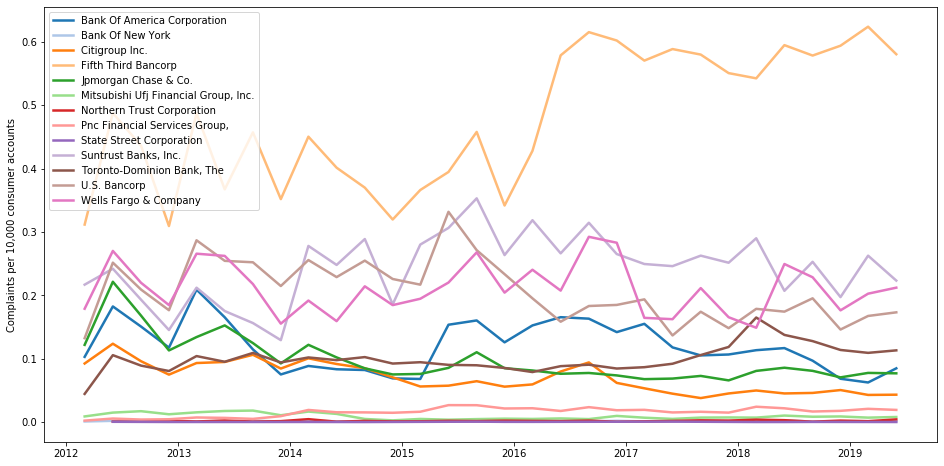

In [37]:
fig, ax = plt.subplots(figsize=(16,8))
colors = plt.cm.tab20(np.linspace(0,1,20))
i = 0
for n, group in top15_accnts.groupby('company_short'):
    accounts_index = pd.to_datetime({'year': group.index.get_level_values(0).year,
                                     'month': group.index.get_level_values(0).month,
                                     'day': 1}).unique()
    plt.plot(accounts_index, group['complaints_per_10k'], label=group['company_short'].unique()[0], 
             color=colors[i], linewidth=2.5)
    i += 1
ax.set_ylabel('Complaints per 10,000 consumer accounts')    
ax.legend()

#### Fifth Third Bankcorp yields the worst statistic for this metric. The settlement for its descriminatory practices in 2015 might be the culprit for its sharp rise in that period. (https://www.consumerfinance.gov/about-us/newsroom/cfpb-takes-action-against-fifth-third-bank-for-auto-lending-discrimination-and-illegal-credit-card-practices/) 
#### Of the "Big Four" banks, Wells Fargo has consistently performed poorly by this complaints metric. Its extensive unauthorized account opening scandal that was charged in 2016 likely had an effect. (https://www.consumerfinance.gov/about-us/newsroom/consumer-financial-protection-bureau-fines-wells-fargo-100-million-widespread-illegal-practice-secretly-opening-unauthorized-accounts/) 
#### The highs for the five most complained about companies in this example are listed

In [30]:
top15_accnts.sort_values('complaints_per_10k', ascending=False).groupby('company_short').head(1).head()

,,company,company_short,complaints,num_indiv_accnts,complaints_per_10k
date,id,,,,,
2019Q1,1070345.0,FIFTH THIRD BANCORP,Fifth Third Bancorp,924.0,14811017.0,0.623860
2015Q3,1131787.0,"SUNTRUST BANKS, INC.","Suntrust Banks, Inc.",342.0,9687838.0,0.353020
2015Q2,1119794.0,U.S. BANCORP,U.S. Bancorp,810.0,24414790.0,0.331766
2016Q3,1120754.0,WELLS FARGO & COMPANY,Wells Fargo & Company,3190.0,109118684.0,0.292342
2012Q2,1039502.0,JPMORGAN CHASE & CO.,Jpmorgan Chase & Co.,2359.0,106539377.0,0.221420


#### "The Big 4" in the second quarter of 2019 (see cautionary note above)

In [31]:
top15_accnts.loc['2019Q2',].sort_values('num_indiv_accnts', ascending=False).head(4)

,company,company_short,complaints,num_indiv_accnts,complaints_per_10k
id,,,,,
1951350.0,CITIGROUP INC.,Citigroup Inc.,1969.0,455318142.0,0.043244
1039502.0,JPMORGAN CHASE & CO.,Jpmorgan Chase & Co.,2235.0,290455000.0,0.076948
1073757.0,BANK OF AMERICA CORPORATION,Bank Of America Corporation,1986.0,234115000.0,0.084830
1120754.0,WELLS FARGO & COMPANY,Wells Fargo & Company,2247.0,105938006.0,0.212105


### Most Complained About Compaines

#### The 15 companies with the largest number of complaints per account.

In [32]:
top15_complaints = parent_child_df.sort_values('complaints_per_10k', ascending=False)
top15_complaints = top15_complaints[(top15_complaints['num_indiv_accnts']>100000) & 
                                    (top15_complaints['complaints']>100)]
top15_complaints_idx = top15_complaints.index.get_level_values(1).unique()[:15]
top15_complaints = top15_complaints.loc[(slice(None),top15_complaints_idx),:].sort_index()

replace_name_dict = {}
for name, name_short in zip(top15_complaints['company'].unique(), top15_complaints['company_short'].unique()) :
    name_spl = name.strip().split()
    if len(name_spl)<=3:
        replace_name = ' '.join(name_spl).title()
    else:
        replace_name = ' '.join(name_spl[:2]).title()
    replace_name_dict[name_short] = replace_name
top15_complaints = top15_complaints.replace({'company_short': replace_name_dict})
top15_complaints

company  \
date   id                                                  
2012Q1 1070345.0                     FIFTH THIRD BANCORP   
       1119794.0                            U.S. BANCORP   
       1131787.0                    SUNTRUST BANKS, INC.   
       1231418.0                            BARCLAYS PLC   
       1249758.0                GENERAL ELECTRIC COMPANY   
...                                                  ...   
2019Q2 1391237.0   BANCO BILBAO VIZCAYA ARGENTARIA, S.A.   
       1447376.0  UNITED SERVICES AUTOMOBILE ASSOCIATION   
       1562859.0                     ALLY FINANCIAL INC.   
       3846375.0             DISCOVER FINANCIAL SERVICES   
       4224000.0                         MP (THRIFT) LLC   

                                company_short  complaints  num_indiv_accnts  \
date   id                                                                     
2012Q1 1070345.0          Fifth Third Bancorp       468.0        15017763.0   
       1119794.0                 U.S. Bancorp       268.0        20240335.0   
       1131787.0         Suntrust Banks, Inc.       250.0        11528354.0   
       1231418.0                 Barclays Plc       274.0          129091.0   
       1249758.0     General Electric Company      1725.0          448889.0   
...                                       ...         ...               ...   
2019Q2 1391237.0                 Banco Bilbao       181.0         3196194.0   
       1447376.0              United Services       347.0         9213533.0   
       1562859.0          Ally Financial Inc.       284.0         3669000.0   
       3846375.0  Discover Financial Services       539.0          876365.0   
       4224000.0              Mp (Thrift) Llc       109.0         1118598.0   

                  complaints_per_10k  
date   id                             
2012Q1 1070345.0            0.311631  
       1119794.0            0.132409  
       1131787.0            0.216857  
       1231418.0           21.225337  
       1249758.0           38.428208  
...                              ...  
2019Q2 1391237.0            0.566299  
       1447376.0            0.376620  
       1562859.0            0.774053  
       3846375.0            6.150405  
       4224000.0            0.974434  

[312 rows x 5 columns]

#### A simple plot of these companies

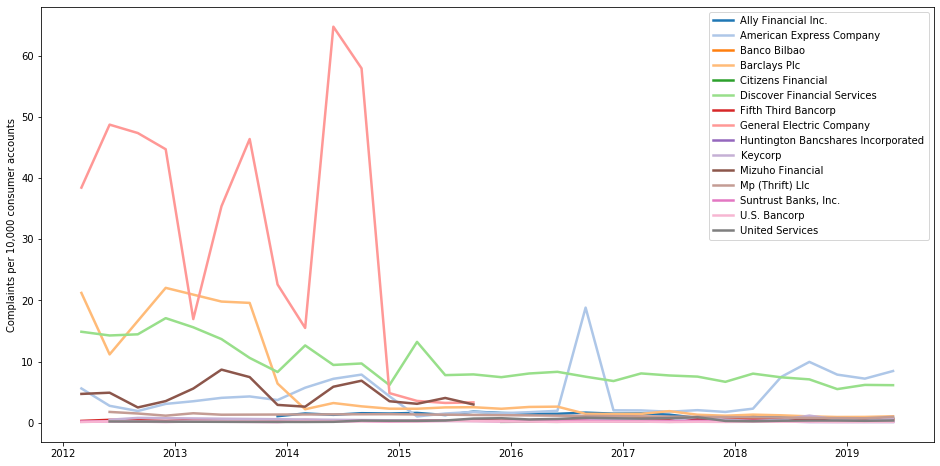

In [35]:
fig, ax = plt.subplots(figsize=(16,8))
colors = plt.cm.tab20(np.linspace(0,1,20))
i = 0
for n, group in top15_complaints.groupby('company_short'):
    complaints_index = pd.to_datetime({'year': group.index.get_level_values(0).year,
                                       'month': group.index.get_level_values(0).month,
                                       'day': 1}).unique()
    plt.plot(complaints_index, group['complaints_per_10k'], label=group['company_short'].unique()[0],
            color=colors[i], linewidth=2.5)
    i += 1
ax.set_ylabel('Complaints per 10,000 consumer accounts')    
ax.legend()

#### While most of the top 15 hard relatively small numbers of complaints, there are a few large, notable exceptions: General Electric, Discover, Barclays, Mizuho Financial, and American Express which peaked in the times listed below. 
#### The complaints have been consistently high for General Electric with a sharp rise in 2014, possibly due to illegal credit card practices that was charged at that time. (https://www.consumerfinance.gov/about-us/newsroom/cfpb-orders-ge-capital-to-pay-225-million-in-consumer-relief-for-deceptive-and-discriminatory-credit-card-practices/) In 2015, GE completed separeation of Synchrony Financial which made up its line of private label credit cards. (https://www.ge.com/reports/ge-completes-the-separation-of-synchrony-financial/)

In [34]:
top15_complaints.sort_values('complaints_per_10k', ascending=False).groupby('company_short').head(1).head()

,,company,company_short,complaints,num_indiv_accnts,complaints_per_10k
date,id,,,,,
2014Q2,1249758.0,GENERAL ELECTRIC COMPANY,General Electric Company,1538.0,237622.0,64.724647
2012Q4,1231418.0,BARCLAYS PLC,Barclays Plc,236.0,107018.0,22.052365
2016Q3,1275216.0,AMERICAN EXPRESS COMPANY,American Express Company,802.0,426105.0,18.821652
2012Q4,3846375.0,DISCOVER FINANCIAL SERVICES,Discover Financial Services,258.0,150839.0,17.104330
2013Q2,3185355.0,"MIZUHO FINANCIAL GROUP, INC.",Mizuho Financial,456.0,524557.0,8.693050
